Reading the papers and their citation graph. Each paper has class assigned. In total there are 7 different classes: Neural net, reinforcemenet learning and ....
Based on the similarity of papers which come from the fact that there are some words in common between them, we can assing a similarity score and therefore assing weights to the edges.


I showed again that in lower dimension the embedding is k-1 dimension instead of k

In [ ]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from sklearn.decomposition import PCA
from sklearn import preprocessing

from gensim.models import Word2Vec

import warnings 
import collections
import matplotlib.pyplot as plt

%matplotlib inline

In [53]:
from cell import  utils

### Read the edge file and creat an undirected graph

Here, it will read a file which has a format like: paper1 paper2, and therefore it is enough to generate a graph from all the nodes and edges

In [30]:
data_dir = "/Users/fahimehb/Documents/GNN/dat/cora/"
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx_wt = nx.read_weighted_edgelist(path=cora_location, create_using=nx.Graph())

In [31]:
print(len(g_nx_wt.edges)) # Number of connection between papers: edges or citations
print(len(g_nx_wt.nodes)) # Number of papers

5278
2708


Here we can read the label for each of the papers (Neural_Network, Rule_learning and ...). Also we have a vector of features which has value 0 or 1 if a word exist in that paper. The column[0] is the paper id. We assign an attribute to each node which will parse the label of that node for us in future. 

In [32]:
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx_wt, values, 'subject')

In [33]:
node_attr

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


Here we will extract the largest connected subgraph for the analysis but this is optional and will not affect the rest of the analysis.

In [34]:
g_nx_wt = max(nx.connected_component_subgraphs(g_nx_wt, copy=True), key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
g_nx_wt.number_of_nodes(), g_nx_wt.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


### Add weight to edges 

For this, we will compute the similarity between nodes based on the features they have. For example in our case, we will have the JSD distance between nodes. So we will generate a matrix which has the size of n_nodes by n_nodes and the values are the similarity between nodes

In [35]:
df = node_attr.copy()
df.set_index(0, inplace = True)
papers = df.index
## calculating the paiwise jaccard similarity between each pair of nodes.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wts = pd.DataFrame(
        1- pairwise_distances(df.iloc[:,:-1].values, metric = 'jaccard'), 
        index = papers, columns = papers)
    wts.index = wts.index.map(str)
    wts.columns = wts.columns.map(str)

In [36]:
wts

,31336,1061127,1106406,13195,37879,1126012,1107140,1102850,31349,1106418,...,626531,1131180,1130454,1131184,1128974,1128975,1128977,1128978,117328,24043
0,,,,,,,,,,,,,,,,,,,,,
31336,1.000000,0.000000,0.000000,0.025000,0.075000,0.064516,0.026316,0.054054,0.190476,0.055556,...,0.000000,0.027778,0.000000,0.000000,0.057143,0.045455,0.000000,0.000000,0.000000,0.026316
1061127,0.000000,1.000000,0.083333,0.027027,0.025641,0.034483,0.090909,0.028571,0.000000,0.093750,...,0.000000,0.030303,0.000000,0.032258,0.030303,0.102564,0.085714,0.060606,0.058824,0.000000
1106406,0.000000,0.083333,1.000000,0.048780,0.022727,0.029412,0.051282,0.051282,0.000000,0.025641,...,0.000000,0.026316,0.000000,0.057143,0.054054,0.043478,0.048780,0.052632,0.000000,0.025000
13195,0.025000,0.027027,0.048780,1.000000,0.023256,0.096774,0.025641,0.052632,0.040000,0.000000,...,0.000000,0.055556,0.000000,0.000000,0.027027,0.044444,0.000000,0.054054,0.000000,0.000000
37879,0.075000,0.025641,0.022727,0.023256,1.000000,0.058824,0.105263,0.050000,0.037037,0.025000,...,0.000000,0.025641,0.040000,0.000000,0.111111,0.020833,0.023256,0.025000,0.024390,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.045455,0.102564,0.043478,0.044444,0.020833,0.026316,0.046512,0.022727,0.000000,0.073171,...,0.000000,0.075000,0.000000,0.025000,0.023810,1.000000,0.021739,0.047619,0.046512,0.022727
1128977,0.000000,0.085714,0.048780,0.000000,0.023256,0.030303,0.052632,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,1.000000,0.054054,0.025641,0.025641
1128978,0.000000,0.060606,0.052632,0.054054,0.025000,0.033333,0.027778,0.027778,0.000000,0.000000,...,0.043478,0.029412,0.000000,0.000000,0.029412,0.047619,0.054054,1.000000,0.000000,0.000000


if an edge exist between two nodes, then we take the value from the weight matrix and assign it to the graph edge

In [37]:
for u,v in g_nx_wt.edges():
    val = wts[u][v]
    g_nx_wt[u][v]['weight'] = val

For example between the two papers '1153262' and '77438', there is a weight of 0.043...

In [38]:
g_nx_wt['1153262']['77438']['weight']

0.04347826086956519

wts matrix is not normalized but it is symmetric!

In [39]:
sum(wts.iloc[2707])

69.24646842715036

In [40]:
sum(wts['24043'])

69.24646842715036

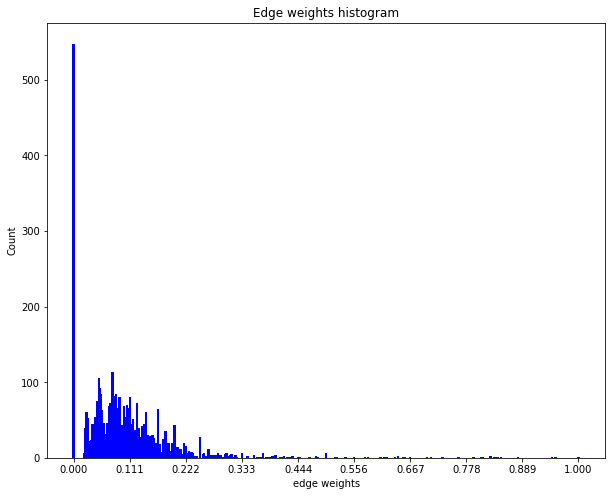

In [41]:
wts = list()
for u,v in g_nx_wt.edges():
    wts.append(g_nx_wt[u][v]['weight'])
wts = sorted(wts, reverse = True)
edgeCount = collections.Counter(wts)
wt, cnt = zip(*edgeCount.items())

plt.figure(figsize=(10,8))
plt.bar(wt, cnt, width=0.005, color='b')
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0,1,10))

plt.show()

### Create a random walk object

First we will generate a random walk object (rw) and then we generate many random walks using the weights. we can trun on or off the weights and also the p and q parameters/

In [57]:
rw = BiasedRandomWalk(StellarGraph(g_nx_wt))

In [62]:
walks = rw.run(
    nodes=g_nx_wt.nodes(), # root nodes
    length=1000,    # maximum length of a random walk
    n=1,          # number of random walks per root node 
    p=0.5,         # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,         # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True)

print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [ ]:
utils.write_list_of_lists_to_csv("//Users/fahimehb/Documents/GNN/dat/cora/", "cora_walks.csv", walks)

### Learn embedding from the random walks and plot TSNE

here we will learn a 128 dimensional embedding for the papers

In [55]:
weighted_model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)

KeyboardInterrupt: 

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors  
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2 , random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(10,8))
plt.scatter(weighted_node_embeddings_2d[:,0], 
            weighted_node_embeddings_2d[:,1], 
            c=node_colours, cmap = "jet", alpha = 0.7)
plt.show()

In [ ]:
scaled_data = preprocessing.StandardScaler().fit_transform(weighted_model.wv.vectors)
pca = PCA(n_components=128)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
plt.xticks(rotation = 90)
plt.show()

### Lets do the same thing with 2d embedding

In [24]:
model_2d = Word2Vec(weighted_walks, size=2, window=5, min_count=0, sg=1, workers=1, iter=20)

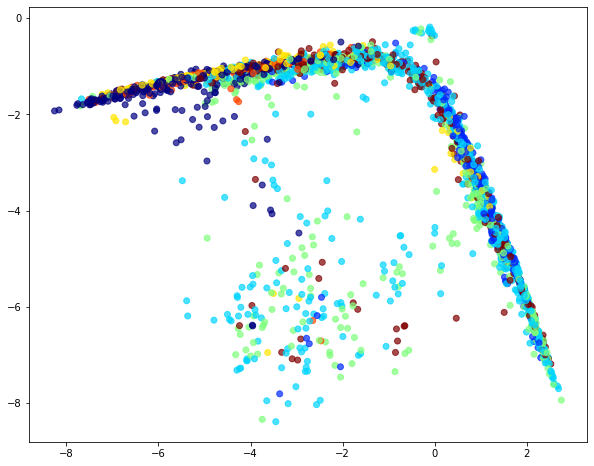

In [25]:
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets ]

plt.figure(figsize=(10,8))
plt.scatter(model_2d.wv.vectors[:,0], 
            model_2d.wv.vectors[:,1],
            c=node_colours, cmap = "jet", alpha = 0.7)
plt.show()

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = model_2d.wv.vectors
pca.fit(X)
#print(pca.components_)
print(pca.explained_variance_)

[9.411143  2.2251856]


### Node classification using logistic regression

We can use the node embedding and the labels of each node to do some downstream task such as node classification

In [73]:
X = weighted_node_embeddings 
y = np.array(node_targets)

Note that we can mix embedding values and standard feature values in the full feature vector. We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=None, random_state = 42)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}" \
          .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [75]:
clf = LogisticRegressionCV(
        Cs=10, 
        cv=10,
        tol=0.001,
        max_iter=1000,
        scoring="accuracy",
        verbose=False,
        multi_class='ovr',
        random_state=5434
    )
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=5434,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.001,
           verbose=False)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=5434,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.001,
           verbose=False)

In [76]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.797427652733119

### Comparison of weighted and unnweighted biased random walks

Number of random walks: 24850


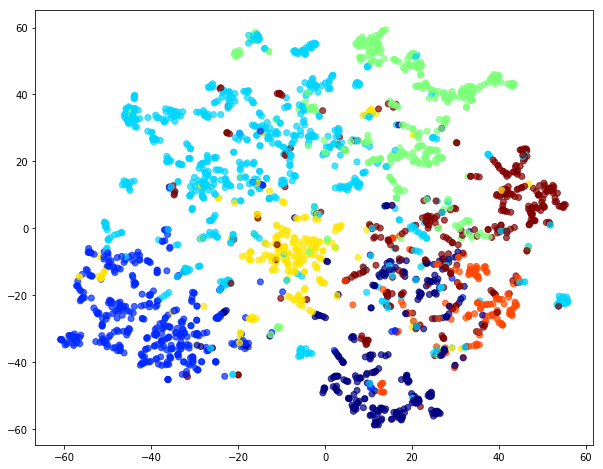

In [77]:
weighted_walks = rw.run(
    nodes=g_nx_wt.nodes(), # root nodes
    length=100,    # maximum length of a random walk
    n=10,          # number of random walks per root node 
    p=0.5,         # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,         # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=False, #for weighted random walks
    seed=42        # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))



weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors  
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2 , random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)


# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(10,8))
plt.scatter(weighted_node_embeddings_2d[:,0], 
            weighted_node_embeddings_2d[:,1], 
            c=node_colours, cmap = "jet", alpha = 0.7)
plt.show()

In [78]:
X = weighted_node_embeddings 
y = np.array(node_targets)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=None, random_state = 42)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}" \
          .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

clf = LogisticRegressionCV(
        Cs=10, 
        cv=10,
        tol=0.001,
        max_iter=1000,
        scoring="accuracy",
        verbose=False,
        multi_class='ovr',
        random_state=5434
    )
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=5434,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.001,
           verbose=False)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


0.8569131832797428

### Testing whether weights = 1 gives identical result to unweighted randomwalks


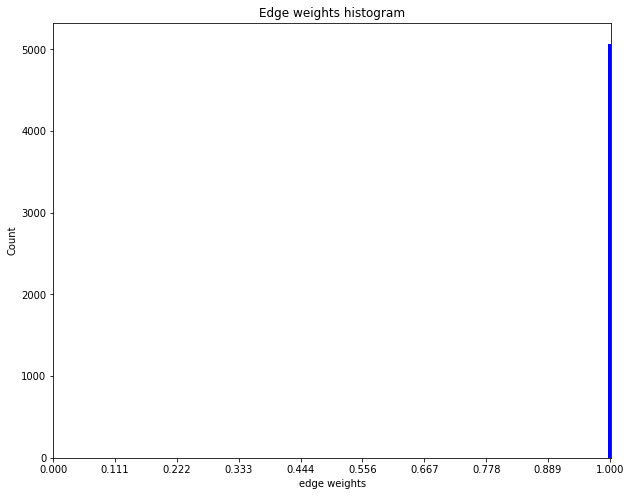

In [79]:
for u,v in g_nx_wt.edges():
        g_nx_wt[u][v]['weight'] = 1
        
wts = list()
for u,v in g_nx_wt.edges():
    wts.append(g_nx_wt[u][v]['weight'])
wts = sorted(wts, reverse = True)
edgeCount = collections.Counter(wts)
wt, cnt = zip(*edgeCount.items())

plt.figure(figsize=(10,8))
plt.bar(wt, cnt, width=0.005, color='b')
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0,1,10))

plt.show()

In [81]:
rw = BiasedRandomWalk(StellarGraph(g_nx_wt))
weighted_walks = rw.run(
        nodes=g_nx_wt.nodes(), # root nodes
        length=100,    # maximum length of a random walk
        n=10,          # number of random walks per root node 
        p=0.5,         # Defines (unormalised) probability, 1/p, of returning to source node
        q=2.0,         # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=True, # indicates the walks are weighted
        seed=42        # seed fixed for reproducibility
    )

In [83]:
#assert walks == weighted_walks

weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)

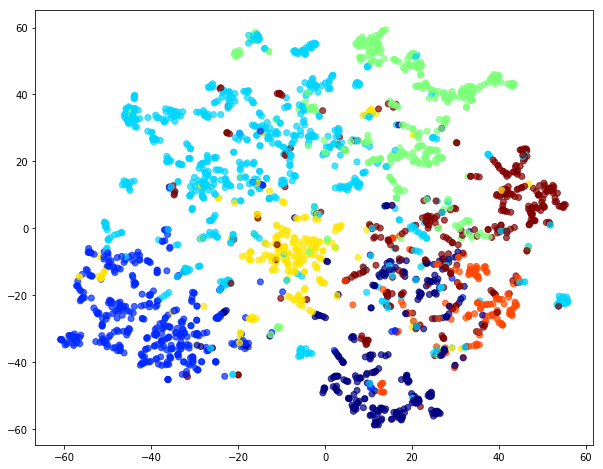

In [84]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]

    # Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

    # draw the points
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(10,8))
plt.scatter(weighted_node_embeddings_2d[:,0], 
                weighted_node_embeddings_2d[:,1], 
                c=node_colours, cmap = "jet", alpha = 0.7)
plt.show()

In [85]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings 
# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}" \
          .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))





clf = LogisticRegressionCV(
        Cs=10, 
        cv=10, 
        tol=0.001,
        max_iter=1000,
        scoring="accuracy",
        verbose=False,
        multi_class='ovr',
        random_state=5434
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)
#np.array_equal(weighted_node_embeddings, node_embeddings)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


NameError: name 'node_embeddings' is not defined